In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
# from jax import config
# config.update("jax_enable_x64", True)

In [3]:
L = 1.
NX = NY = 128
X_START = 0.
X_END = L
Y_START = 0.
Y_END = L
TOL = 1e-2

In [4]:
x = jnp.linspace(X_START, X_END, NX + 1)
y = jnp.linspace(Y_START, Y_END, NY + 1)
X, Y = jnp.meshgrid(x, y)

In [5]:
dx = x[1] - x[0]
dy = y[1] - y[0]

In [6]:
d = -2 * (1/dx**2 + 1/dy**2)

In [7]:
u = lambda x, y: (x**2 - 1.)*(y**2 - 1.)
f = lambda x, y: -2.*(2. - x**2 - y**2)

In [8]:
U = u(X, Y)
F = f(X, Y)

In [39]:
u_init = U.at[1:-1, 1:-1].set(0)
index_arr_bc_64 = index_arr_bc_64_prolong = jnp.arange((NX+1)/2, dtype=jnp.int32)
index_arr_int_64 = jnp.arange(1, NX/2, dtype=jnp.int32)
index_arr_int_64_prolong = jnp.arange(NX/2, dtype=jnp.int32)
index_arr_int_128 = jnp.arange(1, NX, dtype=jnp.int32)
index_arr_128_ravel_start, index_arr_128_ravel_end = (jnp.arange((NX+1) * (NX+1)).reshape(NX+1,NX+1))[1,0],\
                                                     (jnp.arange((NX+1) * (NX+1)).reshape(NX+1,NX+1))[-2,-1]
index_arr_64_ravel_start, index_arr_64_ravel_end = (jnp.arange((NX+2)/2 * (NX+2)/2, dtype=jnp.int32).reshape(int((NX+2)/2),int((NX+2)/2)))[1,0],\
                                                   (jnp.arange((NX+2)/2 * (NX+2)/2, dtype=jnp.int32).reshape(int((NX+2)/2),int((NX+2)/2)))[-2,-1]
mesh_grid_nums = ((129, 129), (65, 65))
mesh_grid_sizes = ((dx, dy),(2*dx, 2*dy))
total_iter_list = (2, 2, 2)
index_128_ign = NX + (NX+1)*jnp.arange(1, NX)
index_64_ign = int(NX/2) + int(NX/2+1)*jnp.arange(1, NX/2, dtype=jnp.int32)

In [10]:
# @jax.jit
# def jacobi(u, f, index_i, index_j, dx, dy, d):
#     u_ijm1, u_ij, u_ijp1, u_im1j, _,  u_ip1j = jnp.hstack((jnp.squeeze(jax.lax.dynamic_slice(u, (index_i, index_j - 1), (1,3))), jnp.squeeze(jax.lax.dynamic_slice(u, (index_i - 1, index_j), (3,1)))))
#     r_ij = f[index_i, index_j] - ((u_ijp1 - 2.*u_ij + u_ijm1)/dx**2) - ((u_ip1j - 2.*u_ij + u_im1j)/dy**2)
#     return u_ij + r_ij/d

@jax.jit
def jacobi_res(u, f, index_i, index_j, dx, dy):
    u_ijm1, u_ij, u_ijp1, u_im1j, _,  u_ip1j = jnp.hstack((jnp.squeeze(jax.lax.dynamic_slice(u, (index_i, index_j - 1), (1,3))), jnp.squeeze(jax.lax.dynamic_slice(u, (index_i - 1, index_j), (3,1)))))
    return f[index_i, index_j] - ((u_ijp1 - 2.*u_ij + u_ijm1)/dx**2) - ((u_ip1j - 2.*u_ij + u_im1j)/dy**2)

@jax.jit
def node_select(index, u, f, row_size, index_ign, dx, dy, d):
    
    def node_compute(index, u, f=f, row_size=row_size, dx=dx, dy=dy, d=d):
        u_ijm1, u_ij, u_ijp1, u_im1j, u_ip1j = jnp.hstack((jax.lax.dynamic_slice_in_dim(u, index - 1, 3),\
                                               jax.lax.dynamic_index_in_dim(u, index - row_size),\
                                              jax.lax.dynamic_index_in_dim(u, index + row_size)))
        r = f[index] -\
            ((u_ijp1 - 2*u_ij + u_ijm1)/dx**2) - ((u_ip1j - 2*u_ij + u_im1j)/dy**2)
        return u.at[index].set(u_ij + r/d)

    cond1 = jnp.squeeze(jnp.mod(index, row_size) == 0)
    cond2 = jnp.any(jnp.isin(index, index_ign),keepdims=False)
    return jax.lax.cond(cond1 | cond2, lambda index, u: u, node_compute, index, u)

In [11]:
@jax.jit
def restriction_intr(r, index_i, index_j):
    center = 4. * r[2*index_i, 2*index_j]
            #4. * jnp.squeeze(jax.lax.dynamic_slice(r, (2*index_i, 2*index_j), (1, 1)))
    
    grid = 2. * (r[2*index_i, 2*index_j + 1] + r[2*index_i, 2*index_j - 1] + \
                r[2*index_i + 1, 2*index_j] + r[2*index_i - 1, 2*index_j])
                #(jnp.squeeze(jax.lax.dynamic_slice(r, (2*index_i, 2*index_j + 1), (1, 1))) + \
                #jnp.squeeze(jax.lax.dynamic_slice(r, (2*index_i, 2*index_j - 1), (1, 1))) + \
                #jnp.squeeze(jax.lax.dynamic_slice(r, (2*index_i + 1, 2*index_j), (1, 1))) + \
                #jnp.squeeze(jax.lax.dynamic_slice(r, (2*index_i - 1, 2*index_j), (1, 1))))
    
    corner =  r[2*index_i + 1, 2*index_j + 1] + r[2*index_i + 1, 2*index_j - 1] + \
              r[2*index_i - 1, 2*index_j + 1] + r[2*index_i - 1, 2*index_j - 1]
                #(jnp.squeeze(jax.lax.dynamic_slice(r, (2*index_i + 1, 2*index_j + 1), (1, 1))) + \
    #             jnp.squeeze(jax.lax.dynamic_slice(r, (2*index_i + 1, 2*index_j - 1), (1, 1))) + \
    #             jnp.squeeze(jax.lax.dynamic_slice(r, (2*index_i - 1, 2*index_j + 1), (1, 1))) + \
    #             jnp.squeeze(jax.lax.dynamic_slice(r, (2*index_i - 1, 2*index_j - 1), (1, 1))))
    
    return (center + grid + corner)/16.

@jax.jit
def restriction_t_bond(r, index_j):
    return r[-1, 2* index_j] #jnp.squeeze(jax.lax.dynamic_slice(r, (size_fine, 2* index_j), (1, 1))))

@jax.jit
def restriction_b_bond(r, index_j):
    return r[0, 2* index_j] #jnp.squeeze(jax.lax.dynamic_slice(r, (0, 2* index_j), (1, 1))))

@jax.jit
def restriction_l_bond(r, index_i):
    return r[2*index_i, 0] #jnp.squeeze(jax.lax.dynamic_slice(r, (2*index_i, 0), (1, 1))))

@jax.jit
def restriction_r_bond(r, index_i):
    return r[2*index_i, -1] #jnp.squeeze(jax.lax.dynamic_slice(r, (2*index_i, size_fine_y), (1, 1))))

@partial(jax.jit, static_argnums=(3,4))
def restriction(r, index_arr_int, index_arr_bc, size_coarse_x, size_coarse_y):
    ec = jnp.zeros((size_coarse_x, size_coarse_y))
    ec = ec.at[1:-1, 1:-1].set(jax.vmap(jax.vmap(restriction_intr, in_axes=(None, None, 0)), in_axes=(None, 0, None))(r, index_arr_int, index_arr_int))
    ec = ec.at[-1, :].set(jax.vmap(restriction_t_bond, in_axes=(None, 0))(r, index_arr_bc))
    ec = ec.at[0, :].set(jax.vmap(restriction_b_bond, in_axes=(None, 0))(r, index_arr_bc))
    ec = ec.at[:, -1].set(jax.vmap(restriction_r_bond, in_axes=(None, 0))(r, index_arr_bc))
    return ec.at[:, 0].set(jax.vmap(restriction_l_bond, in_axes=(None, 0))(r, index_arr_bc))



In [12]:
@jax.jit
def prolongation_intr(index_i, index_j):
    return jnp.hstack((2*index_i, 2*index_j, index_i, index_j), dtype=jnp.int32)
    
@jax.jit
def prolongation_t_bond(index_j):
    return jnp.hstack((-1, 2*index_j, -1, index_j), dtype=jnp.int32)

@jax.jit
def prolongation_b_bond(index_j):
    return jnp.hstack((0, 2*index_j, 0, index_j), dtype=jnp.int32)

@jax.jit
def prolongation_r_bond(index_i):
    return jnp.hstack((2*index_i, -1, index_i, -1), dtype=jnp.int32)

@jax.jit
def prolongation_l_bond(index_i):
    return jnp.hstack((2*index_i, 0, index_i, 0), dtype=jnp.int32)

@partial(jax.jit, static_argnums=(3,4))
def prolongation(unc, index_arr_int, index_arr_bc, size_fine_x, size_fine_y): # size_coarse_x, size_coarse_y
    ef = jnp.zeros((size_fine_x, size_fine_y))
    
    intr_points = jax.vmap(jax.vmap(prolongation_intr, in_axes=(None, 0)), in_axes=(0,None))(index_arr_int, index_arr_int)
    ef = ef.at[intr_points[:,:,0], intr_points[:,:,1]].set(unc[intr_points[:,:,2], intr_points[:,:,3]]) # direct_inj
    ef = ef.at[intr_points[:,:,0], intr_points[:,:,1] + 1].set(0.5*(unc[intr_points[:,:,2], intr_points[:,:,3]] +\
                                                                    unc[intr_points[:,:,2], intr_points[:,:,3] + 1])) # east neigh
    ef = ef.at[intr_points[:,:,0] + 1, intr_points[:,:,1]].set(0.5*(unc[intr_points[:,:,2], intr_points[:,:,3]] +\
                                                                    unc[intr_points[:,:,2] + 1, intr_points[:,:,3]])) # north neigh
    ef = ef.at[intr_points[:,:,0] + 1, intr_points[:,:,1] + 1].set(0.25*(unc[intr_points[:,:,2], intr_points[:,:,3]] +\
                                                                         unc[intr_points[:,:,2] + 1, intr_points[:,:,3]] +\
                                                                         unc[intr_points[:,:,2], intr_points[:,:,3] + 1] +\
                                                                         unc[intr_points[:,:,2] + 1, intr_points[:,:,3] + 1])) # north neigh

    bndry_points = jax.vmap(prolongation_t_bond, in_axes=0)(index_arr_bc)
    ef = ef.at[bndry_points[:,0], bndry_points[:, 1]].set(unc[bndry_points[:,2], bndry_points[:,3]])
    
    bndry_points = bndry_points.at[:].set(jax.vmap(prolongation_b_bond, in_axes=0)(index_arr_bc))
    ef = ef.at[bndry_points[:,0], bndry_points[:, 1]].set(unc[bndry_points[:,2], bndry_points[:,3]])
    
    bndry_points = bndry_points.at[:].set(jax.vmap(prolongation_r_bond, in_axes=0)(index_arr_bc))
    ef = ef.at[bndry_points[:,0], bndry_points[:, 1]].set(unc[bndry_points[:,2], bndry_points[:,3]])
    
    bndry_points = bndry_points.at[:].set(jax.vmap(prolongation_l_bond, in_axes=0)(index_arr_bc))
    ef = ef.at[bndry_points[:,0], bndry_points[:, 1]].set(unc[bndry_points[:,2], bndry_points[:,3]])
    
    return ef

In [38]:
@partial(jax.jit, static_argnames = ('mesh_grid_nums'))
def multigrid(u_init, f, index_128_ign, index_64_ign, index_arr_int_128_start,\
              index_arr_int_128_end, index_arr_int_64_start, index_arr_int_64_end, index_arr_int_128, index_arr_int_64, index_arr_bc_64,\
              index_arr_bc_64_prolong, mesh_grid_nums, mesh_grid_sizes, total_iter_list, U, tol):
   
    @jax.jit
    def relaxation(u_ravel, f_ravel, row_size, index_ign, index_arr_start, index_arr_end, total_iter, dx, dy, d):
        node_select_special = lambda index, u: node_select(index, u, f_ravel, row_size, index_ign, dx, dy, d)
        gauss_siedel = lambda iter, u: jax.lax.fori_loop(index_arr_start, index_arr_end, node_select_special, u)
        # jacobi_special = lambda iter, u : jax.vmap(jax.vmap(jacobi, in_axes=(None, None, None, 0, None, None, None)),\
        #                                            in_axes=(None, None, 0, None, None, None, None))\
        #                                            (u, f, index_arr, index_arr, dx, dy, d)
        return jax.lax.fori_loop(0, total_iter, gauss_siedel, u_ravel)
    
    residual_compute = jax.jit(lambda u, f, index_arr, dx, dy : jax.vmap(jax.vmap(jacobi_res, \
                                                                        in_axes=(None, None, None, 0, None, None)),\
                                                                        in_axes=(None, None, 0, None, None, None))\
                                                                        (u, f, index_arr, index_arr, dx, dy))
    def while_body_fun(iter, u):
        # solve for mesh size 128 x 128
        row_size_fine, col_size_fine = mesh_grid_nums[0]
        dx, dy = mesh_grid_sizes[0]
        d = -2 * (1/dx**2 + 1/dy**2)
        u_witout_corr = jnp.ravel(u.at[1:-1, 1:-1].set(0))
        f_ravel = jnp.ravel(f)
        u_witout_corr = u_witout_corr.at[:].set(relaxation(jnp.ravel(u), f_ravel, row_size_fine,\
                                                        index_128_ign, index_arr_int_128_start, index_arr_int_128_end,\
                                                        total_iter_list[0], dx, dy, d))
        u_witout_corr = u_witout_corr.reshape(row_size_fine, col_size_fine)
        
        # calculate residual for restriction
        r_128 = jnp.zeros_like(u)
        r_128 = r_128.at[1:-1,1:-1].set(residual_compute(u_witout_corr, f, index_arr_int_128, dx, dy))

        # restriction to 64 x 64
        row_size_coarse, col_size_coarse = mesh_grid_nums[1]
        fc = restriction(r_128, index_arr_int_64, index_arr_bc_64, row_size_coarse, col_size_coarse)

        # solve for mesh size 64 x 64
        fc_ravel = jnp.ravel(fc)
        unc = jnp.ravel(jnp.zeros_like(fc))
        dx, dy = mesh_grid_sizes[1]
        d = -2 * (1/dx**2 + 1/dy**2) 
        unc = unc.at[:].set(relaxation(unc, fc_ravel, row_size_coarse,\
                                       index_64_ign, index_arr_int_64_start, index_arr_int_64_end,\
                                       total_iter_list[1], dx, dy, d))
        unc = unc.reshape(row_size_coarse, col_size_coarse)

        # prolongation to 128 x 128
        corr = prolongation(unc, index_arr_int_64_prolong, index_arr_bc_64_prolong, row_size_fine, col_size_fine)
                
        # # adding correction to fine mesh
        u_corr = u_witout_corr.at[1:-1, 1:-1].add(corr[1:-1, 1:-1])
        
        # solve for mesh size 128 x 128
        dx, dy = mesh_grid_sizes[0]
        d = -2 * (1/dx**2 + 1/dy**2)
        u_corr = jnp.ravel(u_corr)
        u_corr = u_corr.at[:].set(relaxation(u_corr, f_ravel, row_size_fine,\
                                            index_128_ign, index_arr_int_128_start, index_arr_int_128_end,\
                                            total_iter_list[2], dx, dy, d))
        
        return u_corr.reshape(row_size_fine, col_size_fine)
    
    def while_check_fun(u):
        return jnp.average(jnp.absolute(u - U)) > tol
        
    return jax.lax.fori_loop(0, 3000, while_body_fun, u_init)

In [40]:
u_num = multigrid(u_init, F, index_128_ign, index_64_ign, index_arr_128_ravel_start, index_arr_128_ravel_end,\
                  index_arr_64_ravel_start, index_arr_64_ravel_end, index_arr_int_128, index_arr_int_64, index_arr_bc_64, index_arr_bc_64_prolong,\
                  mesh_grid_nums, mesh_grid_sizes, total_iter_list, U, TOL)

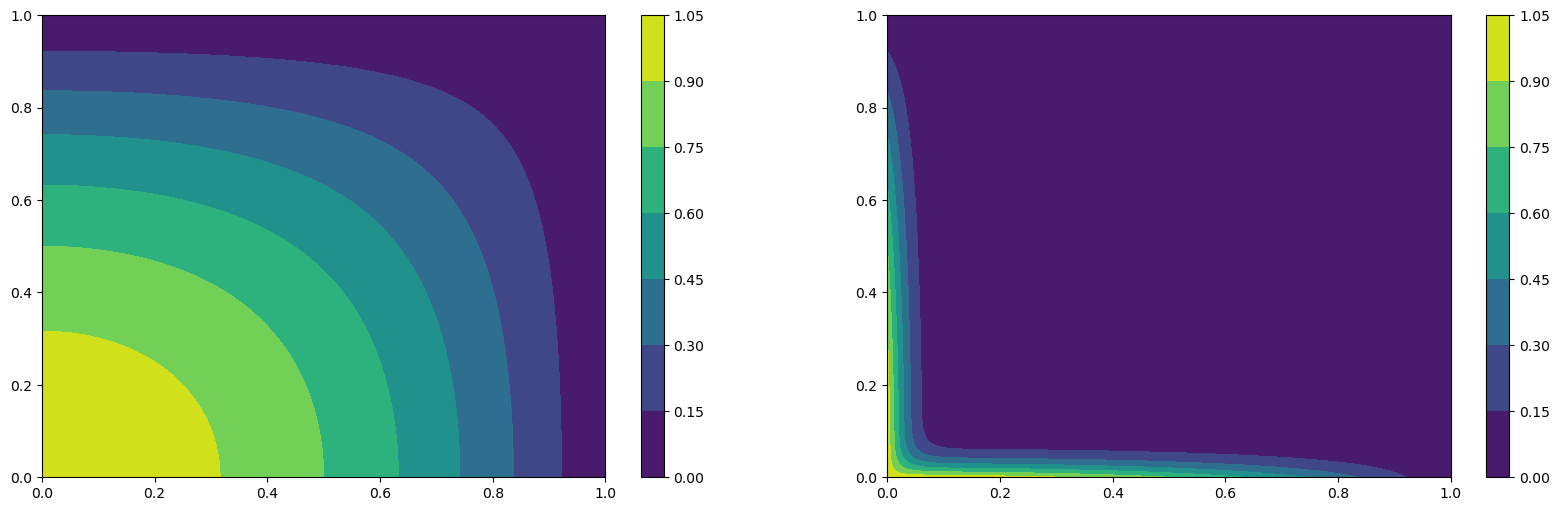

In [24]:
fig, axs = plt.subplots(1,2, figsize=(20, 6))
true = axs[0].contourf(X, Y, U)
num = axs[1].contourf(X, Y, u_num)

fig.colorbar(true)
fig.colorbar(num)
plt.show()
